## Lab 2: Supervised Learning

In this lab, we will investigate the determining factors of a loan size, how much of a loan gets funded, and how long it takes a loan to get funded

### Import Packages

In [3]:
from ggplot import *
import pandas as pd
import numpy as np
%matplotlib inline

/Users/erourke/anaconda/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/erourke/anaconda/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/erourke/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load the Data

In [4]:
data_path = '/Users/erourke/Desktop'
loans_full = pd.read_csv(data_path+'/loans_full.csv', low_memory=False)
loans_details = pd.read_csv(data_path+'/loans_details.csv', low_memory=False)

In [6]:
additional_columns =  loans_full.columns.difference(loans_details.columns).tolist() + ['id']
df = loans_details.merge(loans_full[['id', 'borrower_count']], left_on='id', right_on='id')
df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')
df['pictured'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]==True)
df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=False) ==True, 'yes', 'no')
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=False) ==True,'yes', 'no')
df.head(3)

,Unnamed: 0,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,...,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,male,pictured,widowed,kids
0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,...,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1,False,False,no,yes
1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,...,to buy timber to make more furniture for his e...,NaN,NaN,NaN,NaN,1,True,False,no,yes
2,2,Home Energy,0.0,False,"[{'first_name': 'Rose', 'last_name': '', 'gend...",NaN,['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,...,to buy a solar lantern.,NaN,NaN,NaN,NaN,1,False,False,no,yes


### Linear Relationships and Implications

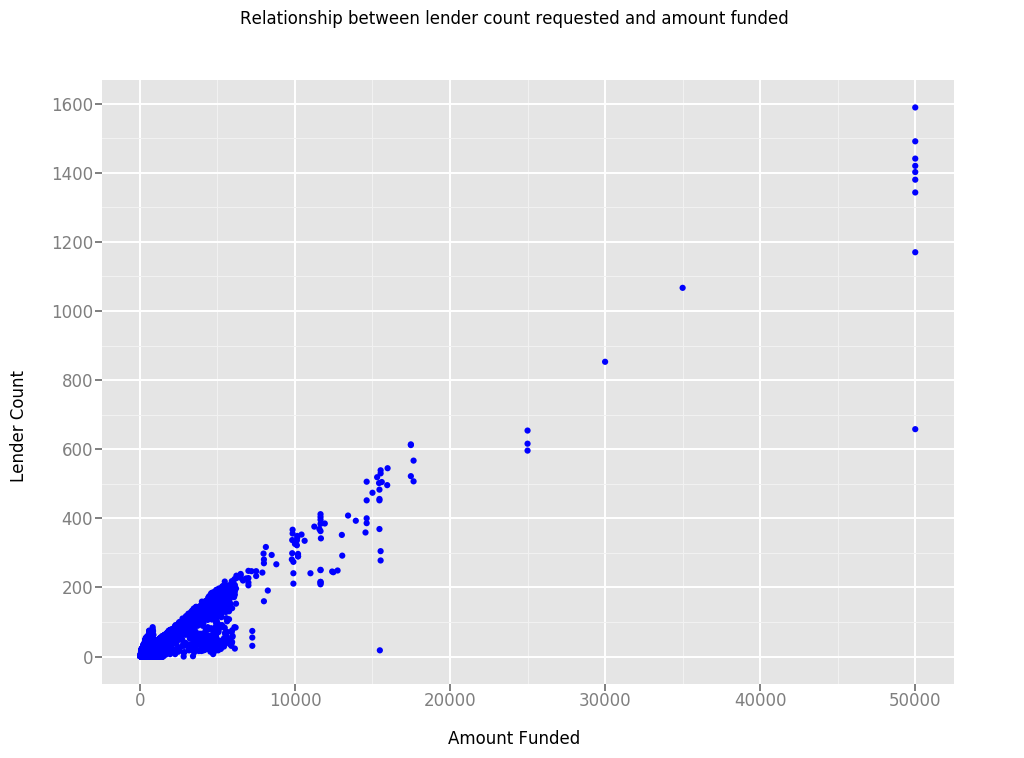

<ggplot: (-9223372036515673628)>

In [7]:
## Example of a linear relationship: What is the relationship between a loan amount and the lender count?

ggplot(loans_full, aes(x='loan_amount', y='lender_count')) + geom_point(color = "blue") + \
ggtitle("Relationship between lender count requested and amount funded") + xlab("Amount Funded") + ylab("Lender Count")

## There seem to be some really large loans skewing the view -- we can zoom in on the loans <$2000 to see 
## the relationship more clearly

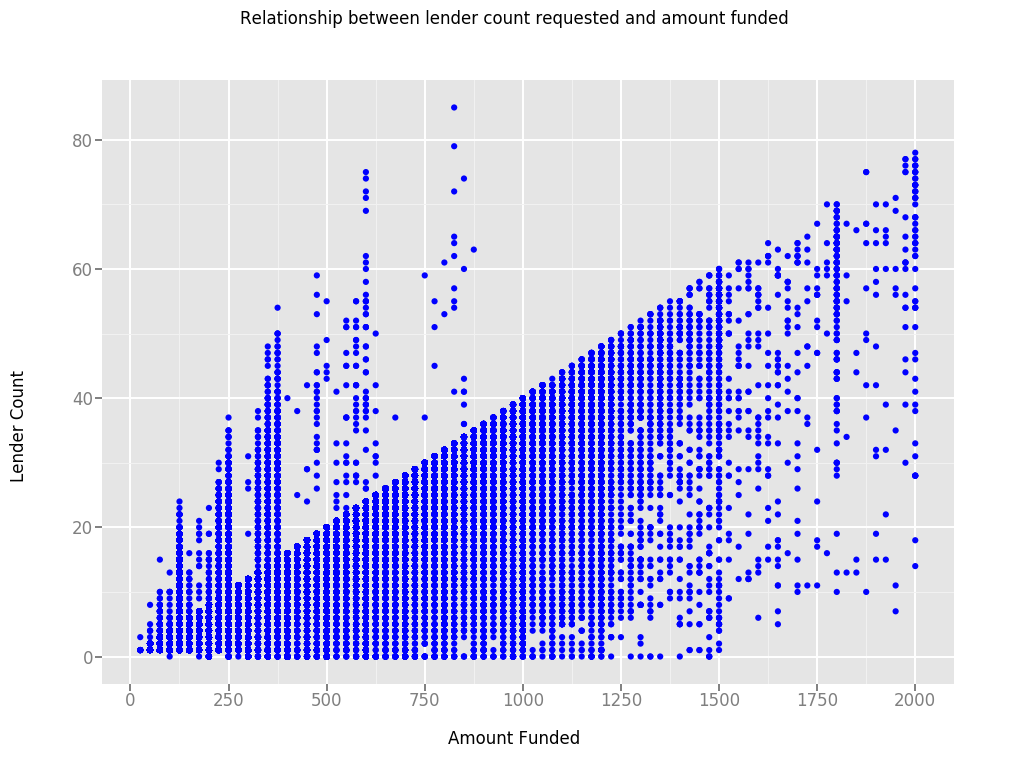

<ggplot: (344530166)>

In [19]:
ggplot(loans_full.query("loan_amount <= 2000"), aes(x='loan_amount', y='lender_count')) + geom_point(color = "blue") + \
ggtitle("Relationship between lender count requested and amount funded") + xlab("Amount Funded") + ylab("Lender Count")

## Interestingly, we see a clear linear path getting traced along a 1:25 ratio of lenders to loan amount
## What happens if we color by loan status?

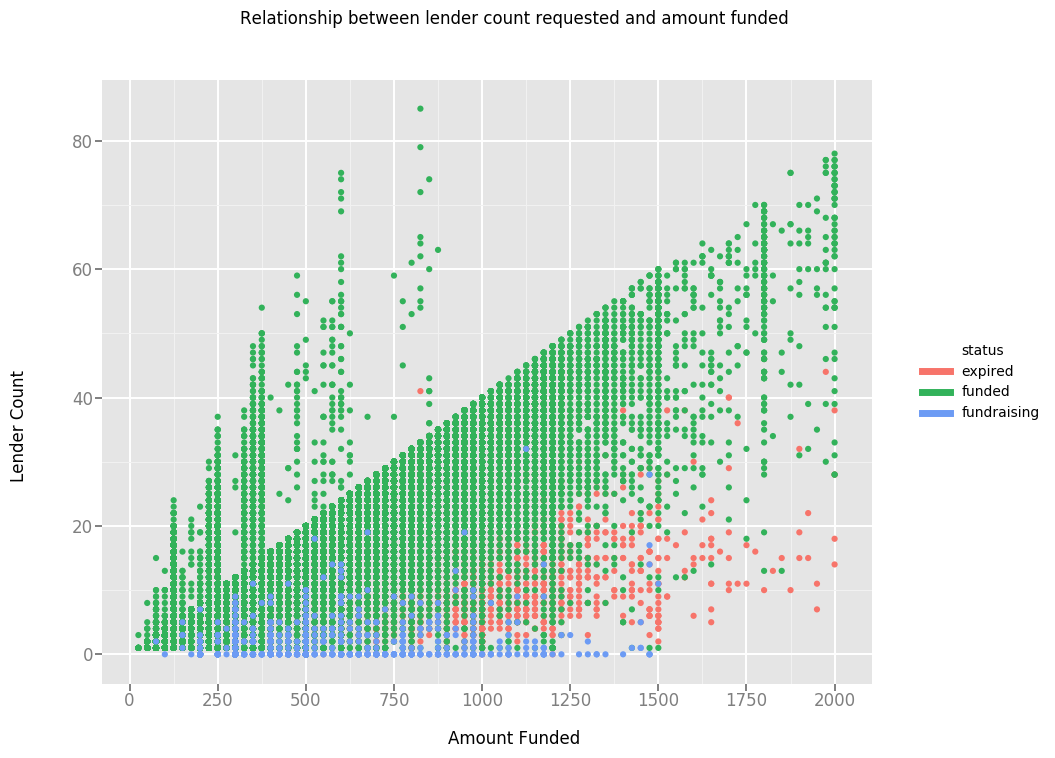

<ggplot: (344531215)>

In [20]:
ggplot(loans_full.query("loan_amount <= 2000"), aes(x='loan_amount', y='lender_count', color='status')) + geom_point() + \
ggtitle("Relationship between lender count requested and amount funded") + xlab("Amount Funded") + ylab("Lender Count")

## Given that lenders typically lend in $25 increments, we see that the expired loans are those that were 
## larger amounts, and did not obtain sufficient lenders

### Normal distribution of variables (plot histogram tables)

In [9]:
## Let's create some time based variables: Specifically, how long it takes a loan to get funded and dispursed

from datetime import datetime
df = df.rename(columns={'terms.disbursal_date': 'disbursal_date'})

## convert columns to datetime format
df['funded_date_cln'] = pd.to_datetime(df.funded_date.str[:10], infer_datetime_format=True)
df['post_date_cln'] = pd.to_datetime(df.posted_date.str[:10], infer_datetime_format=True)
df['disb_date_cln'] = pd.to_datetime(df.disbursal_date.str[:10], infer_datetime_format=True)

## Time to fund is the funded date minues the posted date
df['time_to_fund'] =df['funded_date_cln'] - df['post_date_cln']
df['days_to_fund'] = df.time_to_fund.dt.days

## Time to dispursement is the Disbursed date minus the Posted Date
df['time_to_disb'] =df['disb_date_cln'] - df['post_date_cln']
df['days_to_disb'] = df.time_to_disb.dt.days

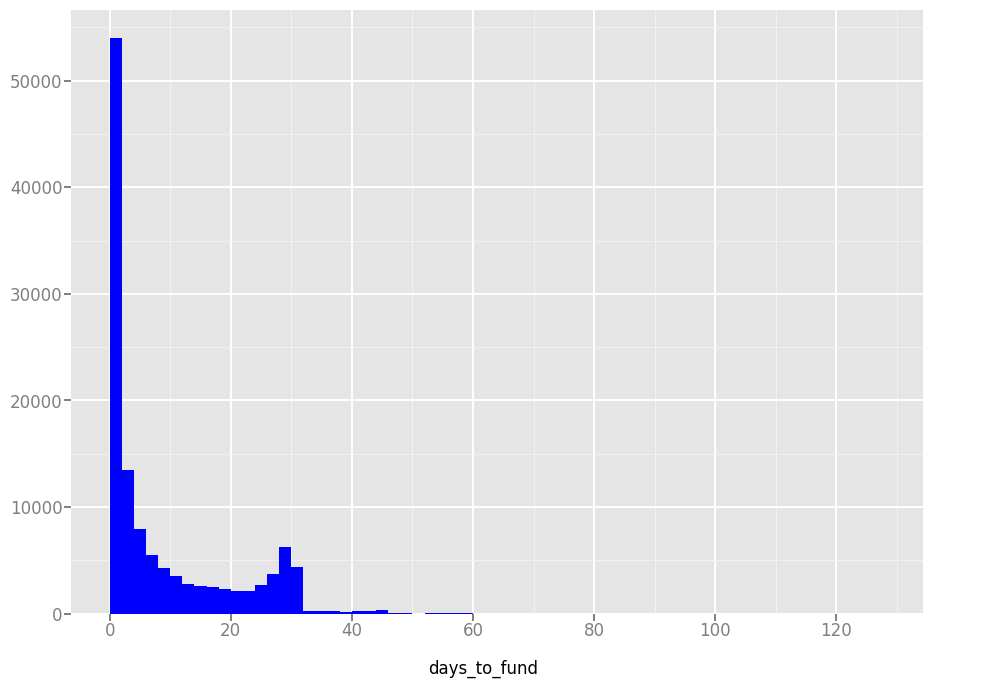

<ggplot: (305608256)>


In [40]:
h = ggplot(df.query('days_to_fund >= 0'), aes(x='days_to_fund')) + geom_histogram(binwidth=2, fill="blue")
print(h)

## Most loans are funded immediately (0 days after being posted)

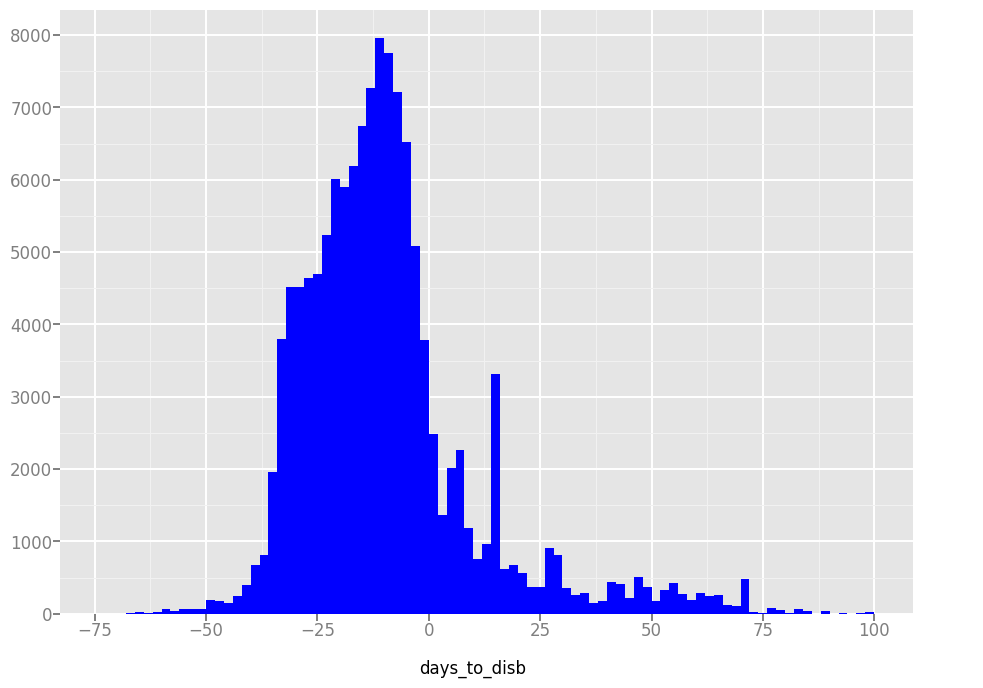

<ggplot: (305551964)>


In [46]:
h = ggplot(df.query('days_to_disb < 100 & days_to_disb > -100'), aes(x='days_to_disb')) + geom_histogram(binwidth=2, fill="blue")
print(h)

## Days to disburse a loan exhibits a normal distribution. Interestingly, it is centered around -10
## Implying that the average loan gets disbursed to the borrower prior to getting posted

### Exploring Potential Relationships in the Data

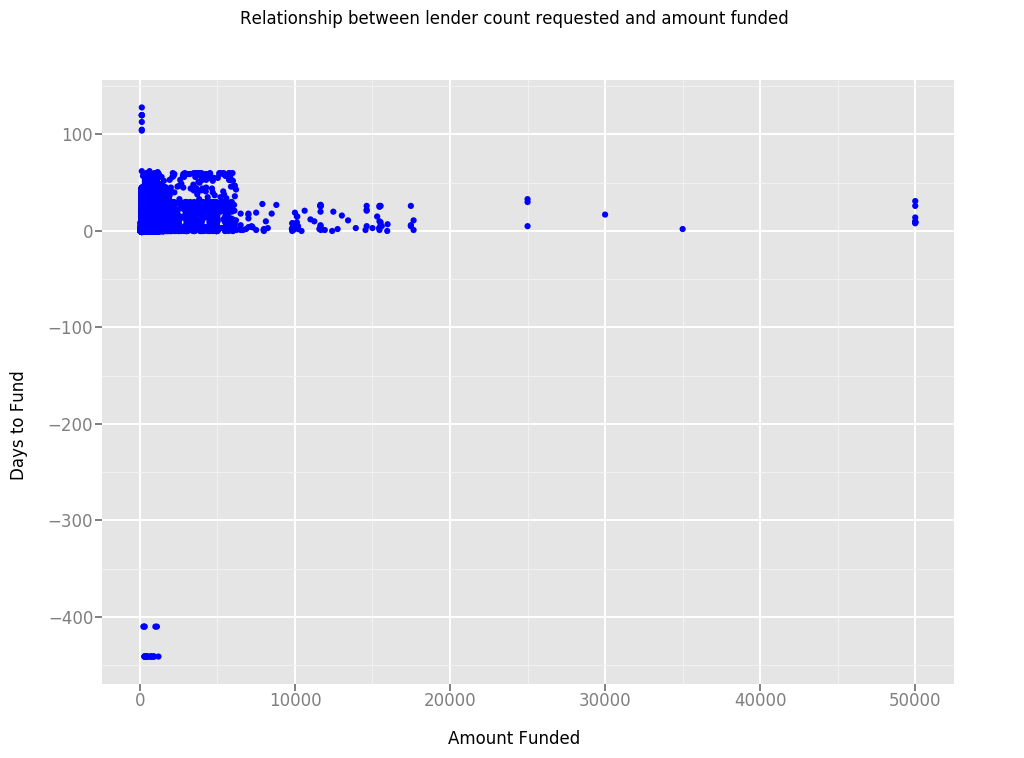

<ggplot: (-9223372036477564356)>

In [161]:
ggplot(df, aes(x='loan_amount', y='days_to_fund')) + geom_point(color = "blue") + \
ggtitle("Relationship between lender count requested and amount funded") + xlab("Amount Funded") + ylab("Days to Fund")

## Clearly, the entries where funding time is negative are erroneous

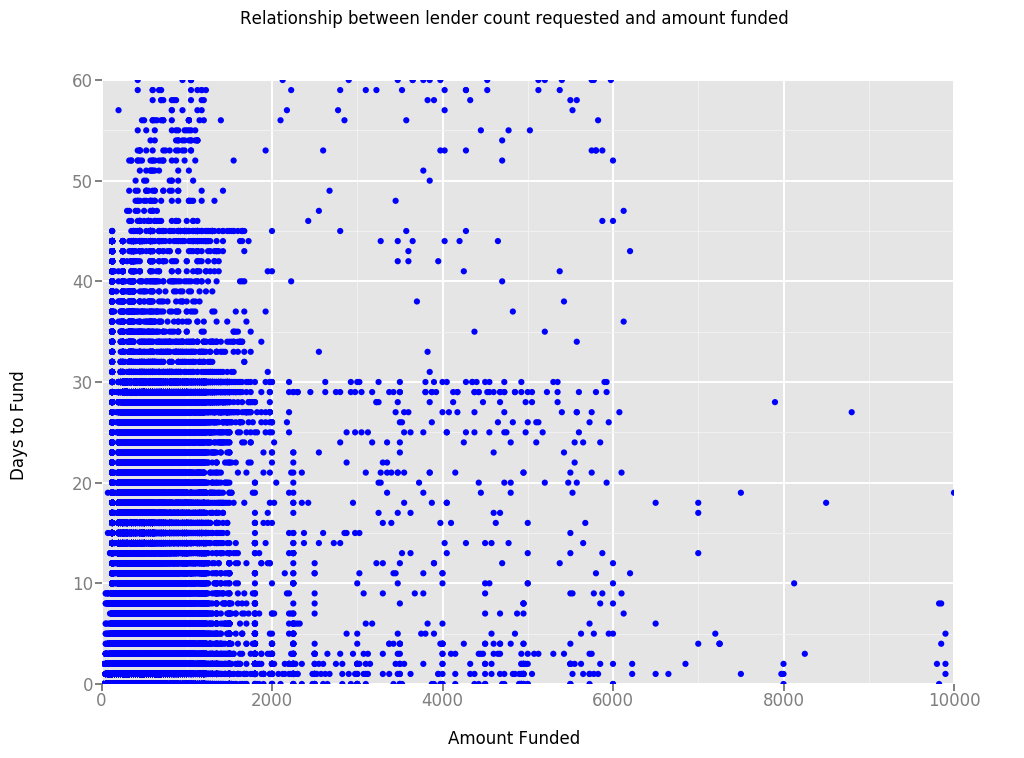

<ggplot: (-9223372036515673663)>

In [10]:
ggplot(df.query("days_to_fund >=0"), aes(x='loan_amount', y='days_to_fund')) + geom_point(color = "blue") + \
ggtitle("Relationship between lender count requested and amount funded") + xlab("Amount Funded") + ylab("Days to Fund") + \
xlim(0,10000) + ylim(0,60)

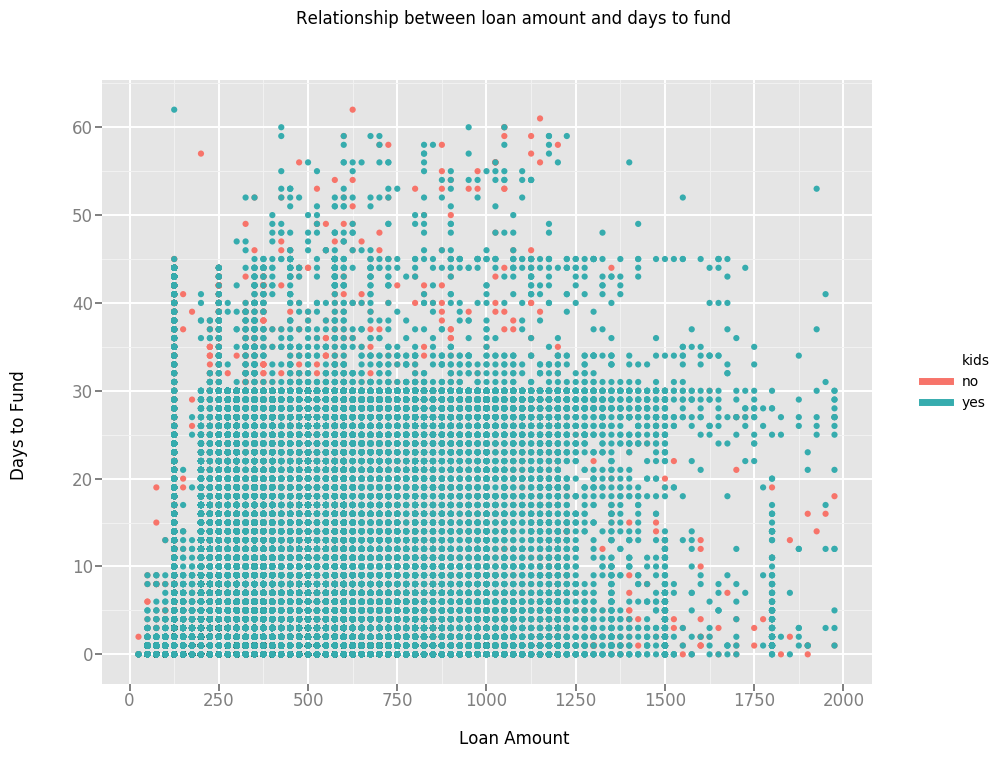

<ggplot: (539233421)>

In [158]:
## No clear linear relationship between time to fund and loan

ggplot(df.query("days_to_fund >=0 & days_to_fund < 80 & loan_amount < 2000"), aes(x='loan_amount', y='days_to_fund', color = 'kids')) + geom_point() + \
ggtitle("Relationship between loan amount and days to fund") + xlab("Loan Amount") + ylab("Days to Fund")


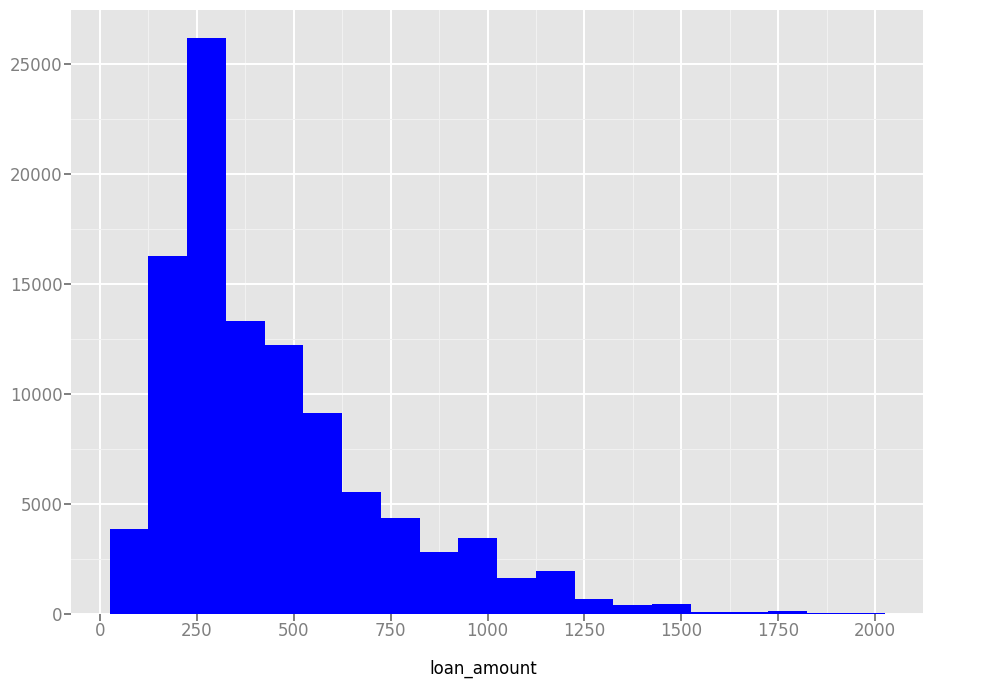

<ggplot: (365617742)>

In [121]:
ggplot(df.query("loan_amount < 2000 & kids == 1"), aes(x='loan_amount')) + \
    geom_histogram(binwidth = 100, fill="blue")

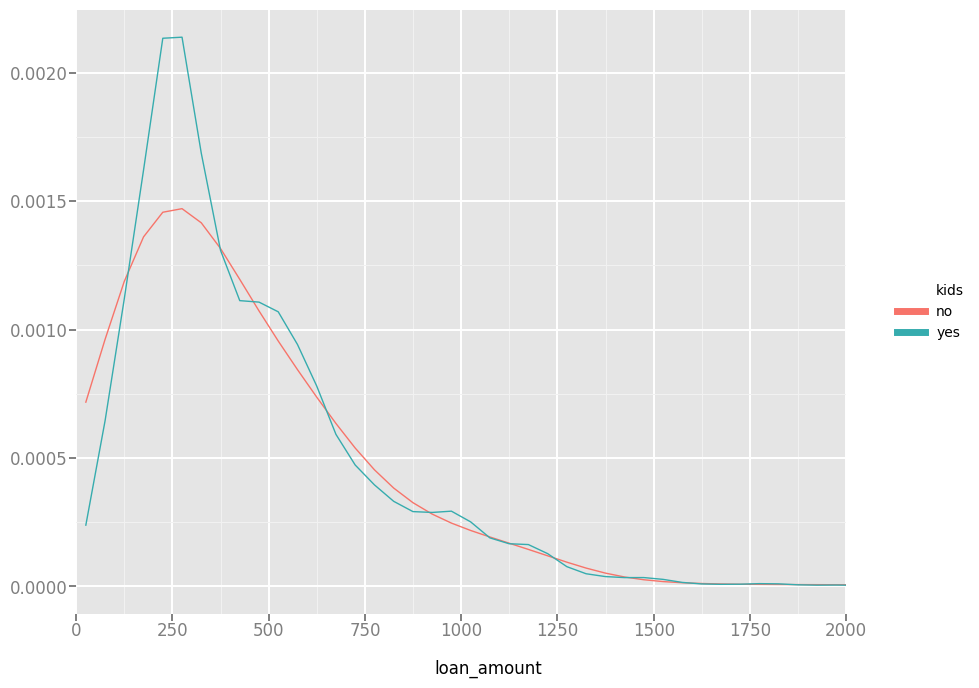

<ggplot: (362423486)>

In [128]:
ggplot(df, aes(x='loan_amount',colour=str('kids'))) + geom_density() + xlim(0,2000)

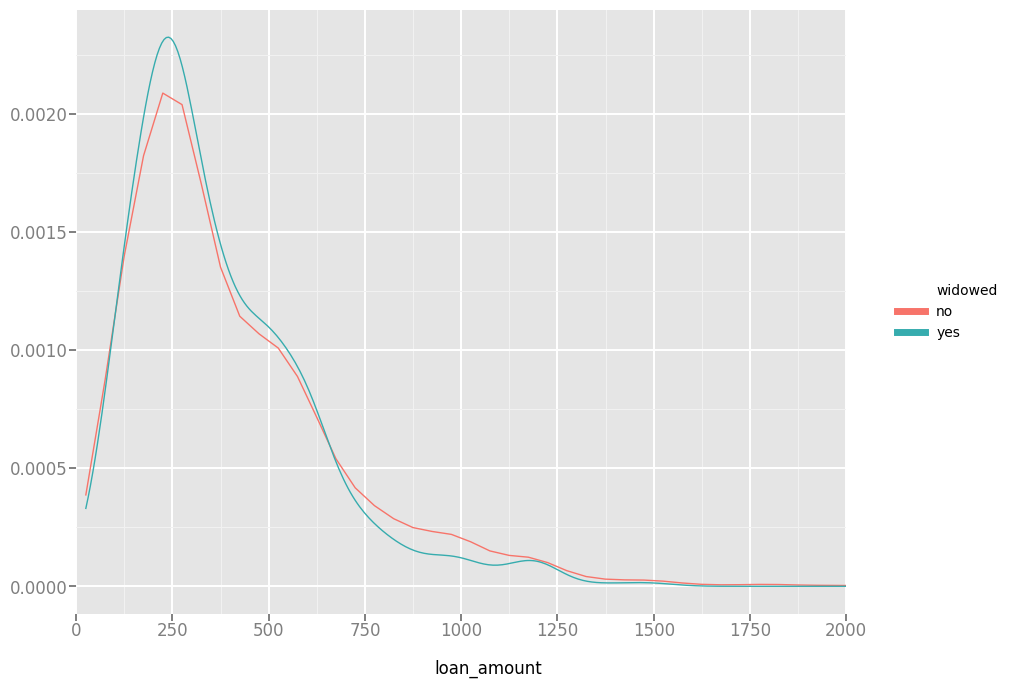

<ggplot: (416503984)>

In [131]:
## widowed women tend to receive smaller loans
ggplot(df.query('male == False'), aes(x='loan_amount',colour=str('widowed'))) + geom_density() + xlim(0,2000)

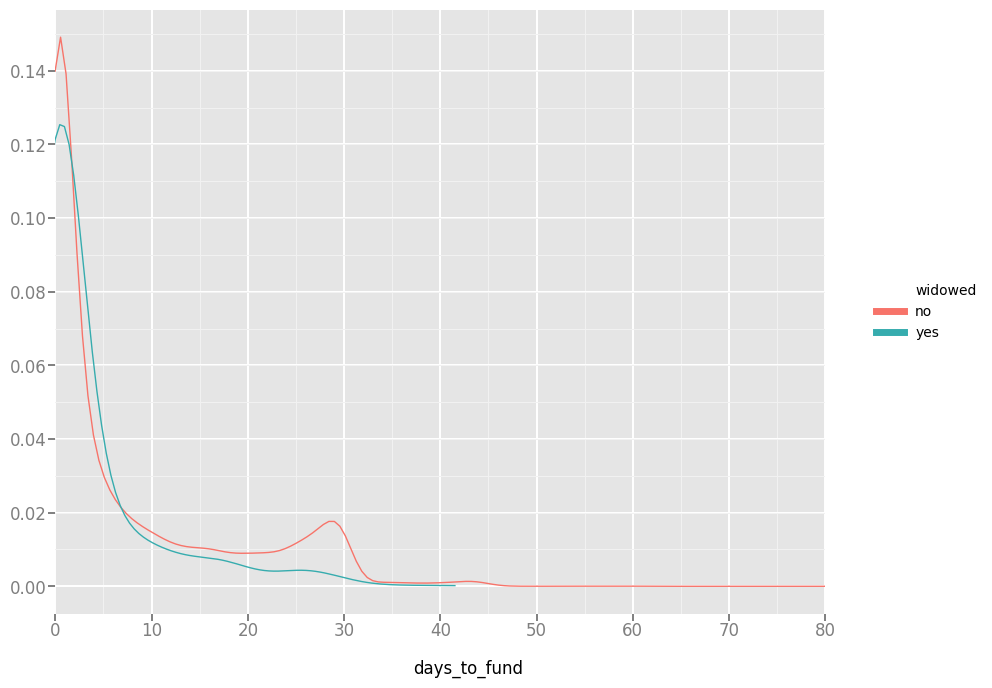

<ggplot: (-9223372036373088764)>

In [145]:
## non-widowed women take longer to fund loans
ggplot(df.query("male == False"), aes(x='days_to_fund',colour=str('widowed'))) + geom_density() + xlim(0,80)

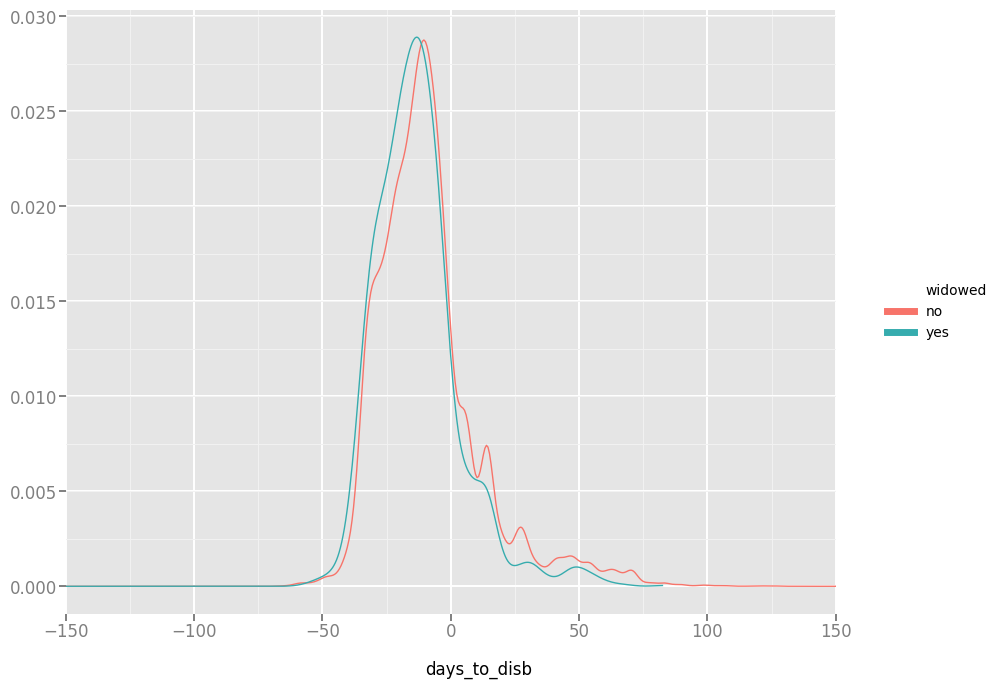

<ggplot: (-9223372036530707540)>

In [148]:
## widowed women have their loans disbursed earlier
ggplot(df.query("male == False"), aes(x='days_to_disb',colour=str('widowed'))) + geom_density() + xlim(-150,150)

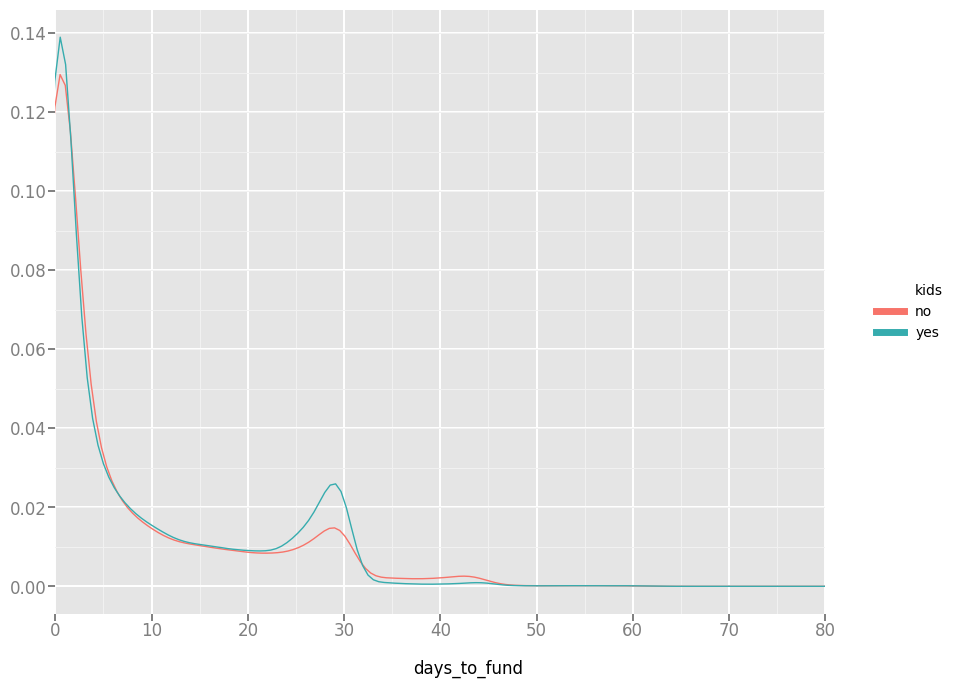

<ggplot: (491896475)>

In [143]:
ggplot(df, aes(x='days_to_fund',colour=str('kids'))) + geom_density() + xlim(0,80)

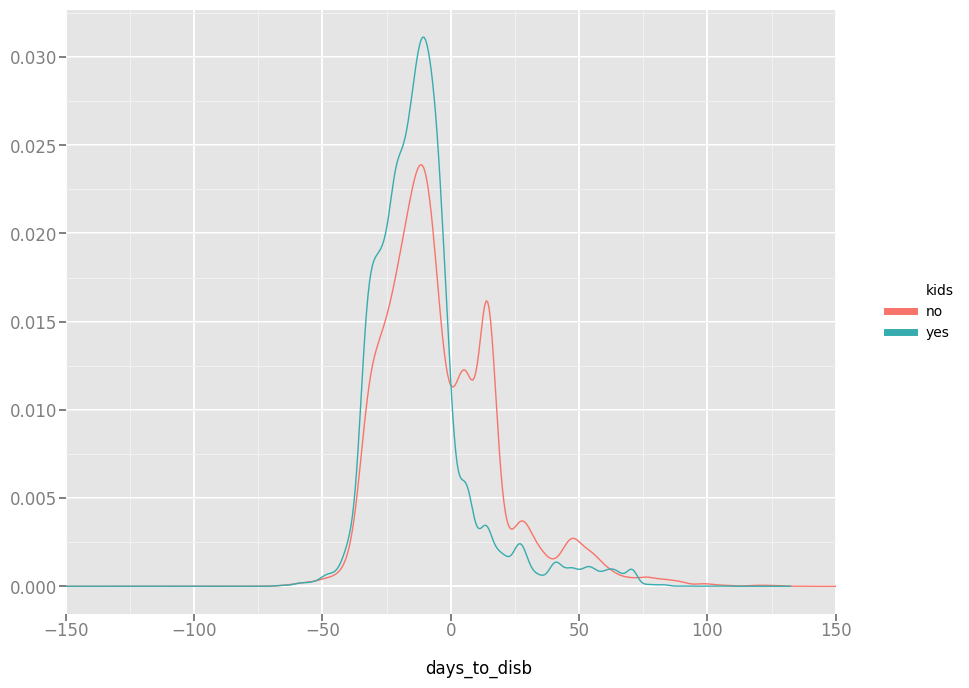

<ggplot: (-9223372036530690286)>

In [149]:
ggplot(df, aes(x='days_to_disb',colour=str('kids'))) + geom_density() + xlim(-150,150)
## loans with kids in the description get dispursed earlier